<center><h2>Projeto final de Machine Learning</h2></center>
<center><h3>Previsão de receita de filmes</h3></center>
<br />
<center>Alunos: Gabriela Caruso, Guilherme Roccato e Pedro Paulo Telho</center>



# Introdução

<p style="text-align: justify" align="justify">A indústria cinematográfica é reconhecida por suas diversas obras primas. Prêmios como Oscar, Globo de Ouro e Emmy são apenas alguns dos que recompensam os seus atores, diretores, produtores etc. Além disso, muito dinheiro é movimentado tanto em forma de investimento para a produção dos filmes como em forma de receita após o lançamento.</p>

<p style="text-align: justify" align="justify">Nesse contexto, o objetivo do projeto é prever quanto de receita um filme pode gerar para que não se tenha prejuízo durante suas produções.</p>
<p style="text-align: justify" align="justify">Para isso, será criado um modelo de regressão através da base de dados: <a href="https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2?select=tmdb_5000_movies.csv" >TMDb 5000 movies dataset</a></p>

# Metodologia

<p style="text-align: justify" align="justify">Nessa seção será apresentada a forma em que o modelo foi construído: bibliotecas necessárias, exploração dos dados e técnicas de inferência para definição do melhor modelo de machine learning para o problema.</p>

### Importando bibliotecas necessárias:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys

import numpy as np
import scipy.sparse

import sklearn.linear_model
import sklearn.datasets
import sklearn.svm
import sklearn.metrics
import sklearn.decomposition
import sklearn.feature_extraction.text
import sklearn.utils.sparsefuncs

import logging

import json

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Carregando os dados:

In [3]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Mesclando créditos e filmes:

In [5]:
credits = credits[['movie_id', 'cast', 'crew']]
credits = credits.rename(columns = {'movie_id': 'id'})
movies = pd.merge(movies,credits,on='id',how='left')

In [6]:
movies_copy = movies.copy()

In [7]:
movies_copy.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Selecionando apenas filmes lançados:

In [8]:
movies_copy = movies_copy.drop(movies_copy[movies_copy.status != 'Released'].index)

Deletando features que não são interessantes para a análise:

In [9]:
movies_copy = movies_copy.drop(columns={'homepage', 'id', 'original_title', 'tagline', 'status', 'crew'})

## Exploração de dados

In [10]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4795 entries, 0 to 4802
Data columns (total 16 columns):
budget                  4795 non-null int64
genres                  4795 non-null object
keywords                4795 non-null object
original_language       4795 non-null object
overview                4792 non-null object
popularity              4795 non-null float64
production_companies    4795 non-null object
production_countries    4795 non-null object
release_date            4794 non-null object
revenue                 4795 non-null int64
runtime                 4793 non-null float64
spoken_languages        4795 non-null object
title                   4795 non-null object
vote_average            4795 non-null float64
vote_count              4795 non-null int64
cast                    4795 non-null object
dtypes: float64(3), int64(3), object(10)
memory usage: 636.8+ KB


Deletando linhas com valores nulos ou zerados:

In [11]:
movies_copy = movies_copy.dropna()

In [12]:
movies_copy = movies_copy[(movies_copy[['budget', 'revenue', 'runtime', 'vote_count']] != 0).all(axis=1)]

### Dataset limpo:

In [13]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 4798
Data columns (total 16 columns):
budget                  3226 non-null int64
genres                  3226 non-null object
keywords                3226 non-null object
original_language       3226 non-null object
overview                3226 non-null object
popularity              3226 non-null float64
production_companies    3226 non-null object
production_countries    3226 non-null object
release_date            3226 non-null object
revenue                 3226 non-null int64
runtime                 3226 non-null float64
spoken_languages        3226 non-null object
title                   3226 non-null object
vote_average            3226 non-null float64
vote_count              3226 non-null int64
cast                    3226 non-null object
dtypes: float64(3), int64(3), object(10)
memory usage: 428.5+ KB


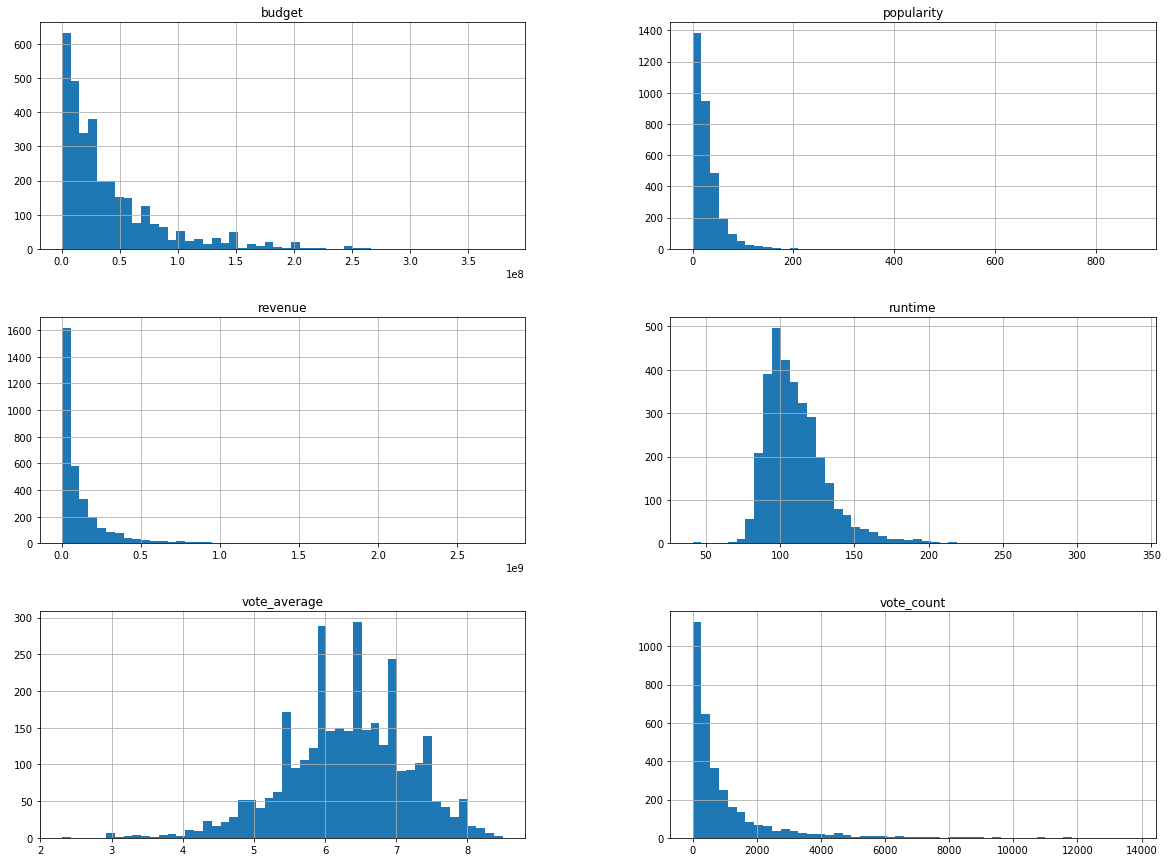

In [14]:
movies_copy.hist(bins=50, figsize=(20, 15))
plt.show()

Visualizando os histogramas acima é possível perceber que não há nenhuma anomalia com a base de dados e, portanto, é posssível continuar com a análise sem nenhuma necessidade de manipulação.

In [15]:
correlation_matrix = movies_copy.corr()

Com a matriz de correlação abaixo pode-se inferir também que a receita de cada filme tem maior correlação com a quantidade de votos (~0.756).

In [16]:
correlation_matrix

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.431629,0.705260,0.229717,-0.036087,0.539916
popularity,0.431629,1.000000,0.602063,0.182385,0.288001,0.748965
revenue,0.705260,0.602063,1.000000,0.233235,0.187830,0.756110
runtime,0.229717,0.182385,0.233235,1.000000,0.386253,0.258103
vote_average,-0.036087,0.288001,0.187830,0.386253,1.000000,0.380685
vote_count,0.539916,0.748965,0.756110,0.258103,0.380685,1.000000


Uma possível razão para tal é que quanto maior a receita gerada por um filme maior alcance esse tem. Assim, uma maior quantidade de pessoas pode fazer parte da votação. Por isso, essa correlação é forte. A mesma lógica pode ser aplicada quando a quantidade de votos é analisada em relação à popularidade (~0.749).


### Análise de texto:

As features que não são quantitativas são representadas por objetos texto. Nesse sentido, é necessário adaptar o modelo para continuar a análise de modelos de regressão.

Para analisar textos foi utilizada a função do scikit-learn `CountVectorizer` com o intuito de transformar textos em vetores númericos e a função `TruncatedSVD` para melhorar a eficiência de trabalho com matrizes esparsas.

In [17]:
movies_ = movies_copy

In [18]:
movies_copy = movies_copy.drop(columns = {'title','release_date','production_countries','spoken_languages'})

In [19]:
text_key = ['genres', 'keywords', 'production_companies', 'cast']

for j in text_key:
    movies_copy[j] = movies_copy[j].apply(lambda x:[i['name'] for i in json.loads(str(x))])
    movies_copy[j] = movies_copy[j].apply(lambda x:", ".join(x))

In [20]:
text_to_num = ['genres', 'keywords', 'original_language', 'production_companies', 'cast', 'overview']

list_of_dfs = []

for i in text_to_num:
    corpus = movies_copy[i]
    n_samples = len(corpus)

    vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1),  #ngram_range=(1, 1) is the default
    dtype='double',)
    data = vectorizer.fit_transform(corpus)

    vectors = data

    pca = sklearn.decomposition.TruncatedSVD(n_components=19)
    data = pca.fit_transform(data)
    
    vectors = data
    
    column_names = []
    for j in range(len(data.tolist()[0])):
        col_name = i + "_" + str(j)
        column_names.append(col_name)
    new_data = pd.DataFrame(vectors.tolist(), columns=column_names)

    list_of_dfs.append(new_data)

In [21]:
list_of_dfs.insert(0, movies_copy)
movies_copy = pd.concat(list_of_dfs, axis=1)
movies_copy.head()

,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,vote_average,...,overview_9,overview_10,overview_11,overview_12,overview_13,overview_14,overview_15,overview_16,overview_17,overview_18
0,237000000.0,"Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",2.787965e+09,162.0,7.2,...,-0.113147,0.108296,-0.203760,-0.190140,-0.200488,0.150020,0.061625,-0.094304,-0.218687,0.096563
1,300000000.0,"Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",9.610000e+08,169.0,6.9,...,-0.172019,-0.000159,-0.108996,-0.186431,0.020970,0.009121,0.049536,-0.183812,-0.379015,-0.056197
2,245000000.0,"Action, Adventure, Crime","spy, based on novel, secret agent, sequel, mi6...",en,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",8.806746e+08,148.0,6.3,...,-0.200125,0.040258,-0.174929,-0.099621,-0.244621,0.245448,0.042358,0.367403,0.104622,0.015275
3,250000000.0,"Action, Crime, Drama, Thriller","dc comics, crime fighter, terrorist, secret id...",en,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",1.084939e+09,165.0,7.6,...,-0.492351,0.442997,0.046381,0.823813,0.510444,1.261701,0.415923,0.344009,-0.056344,-0.731358
4,260000000.0,"Action, Adventure, Science Fiction","based on novel, mars, medallion, space travel,...",en,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,2.841391e+08,132.0,6.1,...,-0.129743,0.023931,-0.058364,-0.161625,-0.258678,0.230172,0.098862,0.161115,-0.530711,-0.000027


In [22]:
movies_copy = movies_copy.drop(columns={'genres', 'keywords', 'original_language', 'production_companies', 'cast', 'overview'})

In [23]:
movies_copy.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,genres_0,genres_1,genres_2,genres_3,...,overview_9,overview_10,overview_11,overview_12,overview_13,overview_14,overview_15,overview_16,overview_17,overview_18
0,237000000.0,150.437577,2.787965e+09,162.0,7.2,11800.0,1.161695,1.297219,0.706028,0.916887,...,-0.113147,0.108296,-0.203760,-0.190140,-0.200488,0.150020,0.061625,-0.094304,-0.218687,0.096563
1,300000000.0,139.082615,9.610000e+08,169.0,6.9,4500.0,0.787288,0.729284,0.482010,0.205881,...,-0.172019,-0.000159,-0.108996,-0.186431,0.020970,0.009121,0.049536,-0.183812,-0.379015,-0.056197
2,245000000.0,107.376788,8.806746e+08,148.0,6.3,4466.0,0.890395,0.685587,0.114349,-0.297282,...,-0.200125,0.040258,-0.174929,-0.099621,-0.244621,0.245448,0.042358,0.367403,0.104622,0.015275
3,250000000.0,112.312950,1.084939e+09,165.0,7.6,9106.0,1.560948,0.159965,-0.922978,-0.519717,...,-0.492351,0.442997,0.046381,0.823813,0.510444,1.261701,0.415923,0.344009,-0.056344,-0.731358
4,260000000.0,43.926995,2.841391e+08,132.0,6.1,2124.0,1.047265,1.248288,0.534182,0.833164,...,-0.129743,0.023931,-0.058364,-0.161625,-0.258678,0.230172,0.098862,0.161115,-0.530711,-0.000027


In [24]:
movies_copy = movies_copy.dropna()

Com a alteração realizada, é possível analisar novamente os valores de correlação dos dados. A feature `vote_count` continua sendo a mais importante para a regressão.

In [25]:
correlation_matrix = movies_copy.corr()
correlation_matrix.unstack().dropna().sort_values(ascending=False).drop_duplicates()

overview_18           overview_18             1.000000
revenue               vote_count              0.760050
vote_count            popularity              0.732853
original_language_17  original_language_15    0.701869
revenue               budget                  0.685696
                                                ...   
original_language_11  original_language_13   -0.491306
original_language_15  original_language_14   -0.739382
original_language_12  original_language_13   -0.766712
original_language_16  original_language_15   -0.819354
                      original_language_17   -0.833910
Length: 7141, dtype: float64

### Separação de dados treinamento/teste

Para manter a integridade dos dados de treinamento/teste é necessário fazer uma separação estratificada. Nesse sentido, foi realizada a separação pela variável `vote_count`.

In [26]:
movies_copy['vote_count'].max()

13752.0

In [27]:
movies_copy['vote_count'].min()

2.0

In [28]:
import math
ref = movies_copy['vote_count'].max()
min_ref = movies_copy['vote_count'].min()
first = math.ceil((ref-min_ref) / 5)
second = math.ceil((ref-min_ref) / 5*2)
third = math.ceil((ref-min_ref) / 5*3)
fourth = math.ceil((ref-min_ref) / 5*4)

In [29]:
def stratified_shuffle(x):
    if x <= first:
        return 1.0
    elif x > first and x <= second:
        return 2.0
    elif x > second and x <= third:
        return 3.0
    elif x > third and x <= fourth:
        return 4.0
    else:
        return 5.0

In [30]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].astype(int)

In [31]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].apply(stratified_shuffle)

In [32]:
movies_copy['vote_count_cat'].value_counts(True)

1.0    0.892607
2.0    0.080934
3.0    0.019455
4.0    0.005447
5.0    0.001556
Name: vote_count_cat, dtype: float64

In [33]:
movies_copy.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,genres_0,genres_1,genres_2,genres_3,...,overview_10,overview_11,overview_12,overview_13,overview_14,overview_15,overview_16,overview_17,overview_18,vote_count_cat
0,237000000.0,150.437577,2.787965e+09,162.0,7.2,11800.0,1.161695,1.297219,0.706028,0.916887,...,0.108296,-0.203760,-0.190140,-0.200488,0.150020,0.061625,-0.094304,-0.218687,0.096563,5.0
1,300000000.0,139.082615,9.610000e+08,169.0,6.9,4500.0,0.787288,0.729284,0.482010,0.205881,...,-0.000159,-0.108996,-0.186431,0.020970,0.009121,0.049536,-0.183812,-0.379015,-0.056197,2.0
2,245000000.0,107.376788,8.806746e+08,148.0,6.3,4466.0,0.890395,0.685587,0.114349,-0.297282,...,0.040258,-0.174929,-0.099621,-0.244621,0.245448,0.042358,0.367403,0.104622,0.015275,2.0
3,250000000.0,112.312950,1.084939e+09,165.0,7.6,9106.0,1.560948,0.159965,-0.922978,-0.519717,...,0.442997,0.046381,0.823813,0.510444,1.261701,0.415923,0.344009,-0.056344,-0.731358,4.0
4,260000000.0,43.926995,2.841391e+08,132.0,6.1,2124.0,1.047265,1.248288,0.534182,0.833164,...,0.023931,-0.058364,-0.161625,-0.258678,0.230172,0.098862,0.161115,-0.530711,-0.000027,1.0


In [34]:
movies_copy = movies_copy.reset_index()

In [35]:
movies_copy = movies_copy.drop(columns = {'index'})

Divisão do conjunto de dados de modo estratificado:

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(movies_copy, movies_copy['vote_count_cat']):
    strat_train_set = movies_copy.loc[train_index]
    strat_test_set = movies_copy.loc[test_index]

Verificando se a separação estratificada foi bem sucedida:

In [37]:
strat_train_set['vote_count_cat'].value_counts(True)

1.0    0.892510
2.0    0.081226
3.0    0.019455
4.0    0.005350
5.0    0.001459
Name: vote_count_cat, dtype: float64

In [38]:
strat_test_set['vote_count_cat'].value_counts(True)

1.0    0.892996
2.0    0.079767
3.0    0.019455
4.0    0.005837
5.0    0.001946
Name: vote_count_cat, dtype: float64

Removendo a nova coluna que foi adicionada temporariamente:

In [39]:
strat_train_set.drop(['vote_count_cat'], axis=1, inplace=True)
strat_test_set.drop(['vote_count_cat'], axis=1, inplace=True)

A partir de agora tem-se os conjuntos de treinamento e teste, `strat_train_set` e `strat_test_set`, respectivamente. O conjunto `strat_train_set` será usado para várias explorações e para construir nosso modelo preditivo. Já o conjunto `strat_test_set` será usado só no final do projeto, para avaliar a performance final do modelo.

### Preparando os dados para o modelo - Separando X e y

Com os conjuntos separados, é possível iniciar a construção de um modelo de machine learning para o problema.

Como o *dataset* foi "limpado" e criou-se referências em numéros para os objetos textos, basta separar as variáveis e construir os modelos preditivos.

In [40]:
strat_train_set_copy = strat_train_set.copy()
strat_test_set_copy = strat_test_set.copy()

Variáveis independentes (dataset original menos a coluna de valores dependentes):

In [41]:
movies = strat_train_set_copy.drop('revenue', axis=1)

Variável dependente (também chamada de label):

In [42]:
movies_labels = strat_train_set_copy['revenue'].copy()

## Construindo modelos preditivos

#### **REGRESSÃO LINEAR:**

O modelo mais simples de regressão é a **regressão linear**, na qual deseja-se estimar um valor dependente como uma combinação linear dos valores independentes. Para esse fim, é necessário treinar um modelo no Scikit-Learn a partir da criação de um regressor, e da chamada do método ``fit()`` deste regressor para ajustar os parâmetros internos do modelo:

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(movies, movies_labels)

LinearRegression()

Para obter as previsões, basta chamar o método `predict()` e comparar com os valores originais para verificar o modelo:

In [44]:
# previsões
predicted_labels = lin_reg.predict(movies)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# valores originais:
print('Original: {}'.format(movies_labels.values.round(decimals=2)))

Predição: [9.53872773e+07 2.74444267e+07 8.29430962e+07 ... 3.60269966e+08
 1.36545335e+08 5.42960036e+08]
Original: [8.54985340e+07 1.20361490e+07 5.49561400e+07 ... 3.49424282e+08
 1.11811453e+08 9.40335536e+08]


Para verificar a eficácia do modelo, pode-se medir o erro de predição no conjunto de treinamento:

In [45]:
from sklearn.metrics import mean_squared_error

movies_predictions = lin_reg.predict(movies)
lin_mse = mean_squared_error(movies_labels, movies_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 106142296.00


In [46]:
residuo = movies_labels - movies_predictions

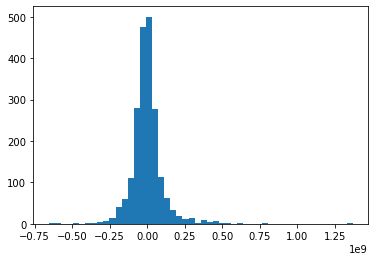

In [47]:
plt.hist(residuo, bins=50);

In [48]:
pd.Series(residuo).describe()

count    2.056000e+03
mean    -6.493891e-09
std      1.061681e+08
min     -6.571870e+08
25%     -4.988433e+07
50%     -5.840190e+06
75%      3.685587e+07
max      1.371673e+09
Name: revenue, dtype: float64

#### **ÁRVORE DE DECISÃO:**

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(movies, movies_labels)

DecisionTreeRegressor(random_state=42)

In [50]:
predicted_labels = tree_reg.predict(movies)
print('Predição: {}'.format(predicted_labels))
print('Original: {}'.format(movies_labels.values))

Predição: [8.54985340e+07 1.20361490e+07 5.49561400e+07 ... 3.49424282e+08
 1.11811453e+08 9.40335536e+08]
Original: [8.54985340e+07 1.20361490e+07 5.49561400e+07 ... 3.49424282e+08
 1.11811453e+08 9.40335536e+08]


In [51]:
movies_predictions = tree_reg.predict(movies)
tree_mse = mean_squared_error(movies_labels, movies_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Árvore de decisão: RMSE = 0.00


#### Overfitting!

#### **RANDOM FOREST:**

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [53]:
forest_reg.fit(movies, movies_labels)

y_pred = forest_reg.predict(movies)
forest_rmse = np.sqrt(mean_squared_error(movies_labels, movies_predictions))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 0.00


#### Overfitting!

### Melhorando a avaliação usando validação cruzada

Para escolher um bom modelo, é necessário tentar estimar o erro de teste do modelo. Nesse sentido, deseja-se treinar o modelo em um certo conjunto de dados, e testá-lo em outro conjunto de dados. Para tal, divide-se o conjunto de treinamento em dois novamente! Usa-se um pedaço para treinar modelos, e outro para testar desempenho.

Isso é necessário pois os verdadeiros dados de teste do modelo não devem ser tocados até que toda a análise esteja pronta.

Por simplicidade a equipe usa a divisão não-estratificada:

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    movies,
    movies_labels,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

#### **REGRESSÃO LINEAR:**

In [55]:
lin_reg.fit(X_train, y_train)

y_pred_rl = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rl))
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 98480081.81


#### **ÁRVORE DE DECISÃO:**

In [56]:
tree_reg.fit(X_train, y_train)

y_pred_tr = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tr))
print('Árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Árvore de decisão: RMSE = 140990853.37


#### **RANDOM FOREST:**

In [57]:
forest_reg.fit(X_train, y_train)

y_pred_rf = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print('Random Forest: RMSE = {:.2f}'.format(forest_rmse))

Random Forest: RMSE = 94076210.31


Parece que o random forest é melhor que os outros modelos, mas talvez todos esses resultados sejam pura sorte. Para verificar pode-se repetir esses experimentos com partições diferentes e ver se o resultado se mantém. O scikit-learn já tem ferramentas para ajudar nessa tarefa:

#### **REGRESSÃO LINEAR:**

In [58]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,  # modelo
    movies,  # X_train
    movies_labels,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

Scores: [8.49639829e+07 9.06035781e+07 1.04598671e+08 1.11619564e+08
 1.04047203e+08 1.42279284e+08 1.69364452e+08 1.04974807e+08
 1.16389107e+08 1.07535943e+08]
Mean: 113637659.19737414
Standard deviation: 23613906.90569162


#### **ÁRVORE DE DECISÃO:**

In [59]:
tree_scores = cross_val_score(
    tree_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [1.17023278e+08 1.38938905e+08 1.23931375e+08 1.35269452e+08
 1.55847165e+08 1.77671275e+08 1.82684778e+08 1.47150721e+08
 1.38256244e+08 1.43054698e+08]
Mean: 145982789.1162714
Standard deviation: 20018614.889678933


#### **RANDOM FOREST:**

In [60]:
forest_scores = cross_val_score(
    forest_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [7.81470609e+07 9.32827124e+07 1.08074939e+08 1.11815940e+08
 9.65085425e+07 1.36917946e+08 1.69845137e+08 1.14777292e+08
 1.14732707e+08 1.09058791e+08]
Mean: 113316106.74705145
Standard deviation: 23927511.056415055


Comparando os três modelos:

Text(0.5, 1.0, 'RMSE / Regressor')

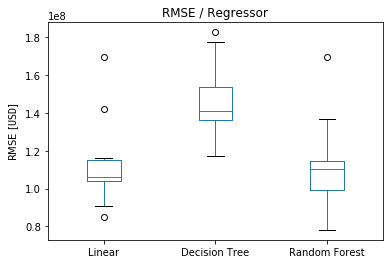

In [61]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Decision Tree': tree_rmse_scores,
    'Random Forest': forest_rmse_scores,
}).plot.box();
plt.ylabel(r'RMSE $[\mathtt{USD}]$')
plt.title("RMSE / Regressor")

Agora sim pode-se perceber que o regressor **linear** é melhor que os outros uma vez que apresenta um menor RMSE e menor desvio padrão.

In [62]:
import time

from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

lin_reg = LinearRegression()

grid_search = GridSearchCV(
    lin_reg,  # Modelo
    parameters,  # Grid
    cv=5,  # Partições de C.V.
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
)

t1 = time.perf_counter()
grid_search.fit(movies, movies_labels)
t2 = time.perf_counter()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 0.51 s


In [63]:
grid_search.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [64]:
grid_search.best_estimator_

LinearRegression()

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

2.248463054855147e+35 {'copy_X': True, 'fit_intercept': True, 'normalize': True}
116395917.74480507 {'copy_X': True, 'fit_intercept': True, 'normalize': False}
116411529.80969892 {'copy_X': True, 'fit_intercept': False, 'normalize': True}
116411529.80969892 {'copy_X': True, 'fit_intercept': False, 'normalize': False}
2.248463054855147e+35 {'copy_X': False, 'fit_intercept': True, 'normalize': True}
116395917.74480507 {'copy_X': False, 'fit_intercept': True, 'normalize': False}
116411529.80969892 {'copy_X': False, 'fit_intercept': False, 'normalize': True}
116411529.80969892 {'copy_X': False, 'fit_intercept': False, 'normalize': False}


Medir o desempenho final:

In [66]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('revenue', axis=1)
y_test = strat_test_set['revenue'].copy()

final_model.fit(X_test, y_test)

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'RMSE = {final_rmse}')

RMSE = 99543801.14814495


# Conclusão

A partir de toda a análise exploratória e construção de diferentes modelos preditivos foi possível identificar o **regressor linear** como o melhor para solucionar esse problema uma vez que apresenta o menor valor de RMSE e menor desvio padrão.

No entanto, é necessário uma análise bem mais rebuscada para que a precisão de inferência seja boa o suficiente para se colocar em prática.

Porém, pelo escopo desse projeto, foi possível desenvolver um modelo de *Machine Learning* capaz de prever a receita de um filme considerando suas outras características.